In [149]:
import numpy as np
import matplotlib.pyplot as plt

In [150]:
n = 2 #number of pipes
if not isinstance(n, int):
    raise ValueError("Number of pipes 'n' must be an integer.")
Q = 93.19 # Q_50 in m3/s
Q_i = Q / n #flow per pipe in m3/s
h_0 = 74 #m
h_end = 175 #m
l_surge = 8300 #length of penstock until surge tank m
l_total = 9300 #total length of penstock m

D_req = np.sqrt((4*Q_i)/(np.pi*V_pipe))

print(f"Required diameter of penstock: {D_req:.2f} m")

Required diameter of penstock: 3.28 m


In [157]:
def penstock_head_loss(D, Q_i, l_total, n):
    xi_ent = 0.1
    xi_ex = 1.0
    xi_bend = 0.5

    Q = Q_i / n # total flow in m3/s
    v = Q / ((np.pi/4) * D**2) # velocity in pipe in m/s

    h_f = 0.015 * (l_total/D) * (v**2/(2*9.81)) # head loss in m

    h_f_ent = xi_ent * ((v**2)/(2*9.81)) # head loss at entrance in m
    h_f_ex = xi_ex * ((v**2)/(2*9.81)) # head loss at exit in m
    h_f_bend = xi_bend * ((v**2)/(2*9.81)) # head loss at bend in m

    h_total_loss = h_f + h_f_ent + (2 * h_f_ex) + (2 * h_f_bend)

    return h_total_loss

def penstock_costs(D, l_total, n):
    cost_per_kg = 1  # EUR/kg
    steel_density = 7850  # kg/m^3
    outer_radius = D / 2
    t_min = D/288
    inner_radius = outer_radius - t_min
    
    # Volume of tube wall
    volume_m3 = np.pi * l_total * (outer_radius**2 - inner_radius**2) * n

    # Mass of steel
    mass_kg = volume_m3 * steel_density
    
    # Total cost
    cost_eur = (mass_kg * cost_per_kg / 10**6)
    
    return cost_eur

def head_loss_cost(Q, h_f):
    hours_per_year=6000
    electricity_price_eur_per_kwh=0.20
    eta = 0.85
    rho = 1000  # kg/m³
    g = 9.81    # m/s²

    # Power lost due to 1 meter head loss (in watts)
    power_watts = rho * g * Q * eta * h_f

    # Convert to kWh/year
    energy_kwh = (power_watts / 1000) * hours_per_year * 50

    # Cost
    cost_eur = energy_kwh * electricity_price_eur_per_kwh / 10**11

    return cost_eur

# Example usage
cost = head_loss_cost(Q=2.0, h_f=1.0)

print(f"Estimated annual cost of 1 meter head loss: €{cost}")

Estimated annual cost of 1 meter head loss: €1.00062e-05


total penstock cost for n=1 at D=2.05 m: €3.32 million
Minimum total cost for n=1 at D=2.05 m: €4.68 million

total penstock cost for n=2 at D=1.52 m: €3.64 million
Minimum total cost for n=2 at D=1.52 m: €5.15 million

total penstock cost for n=3 at D=1.27 m: €3.86 million
Minimum total cost for n=3 at D=1.27 m: €5.45 million

total penstock cost for n=4 at D=1.14 m: €4.10 million
Minimum total cost for n=4 at D=1.14 m: €5.68 million



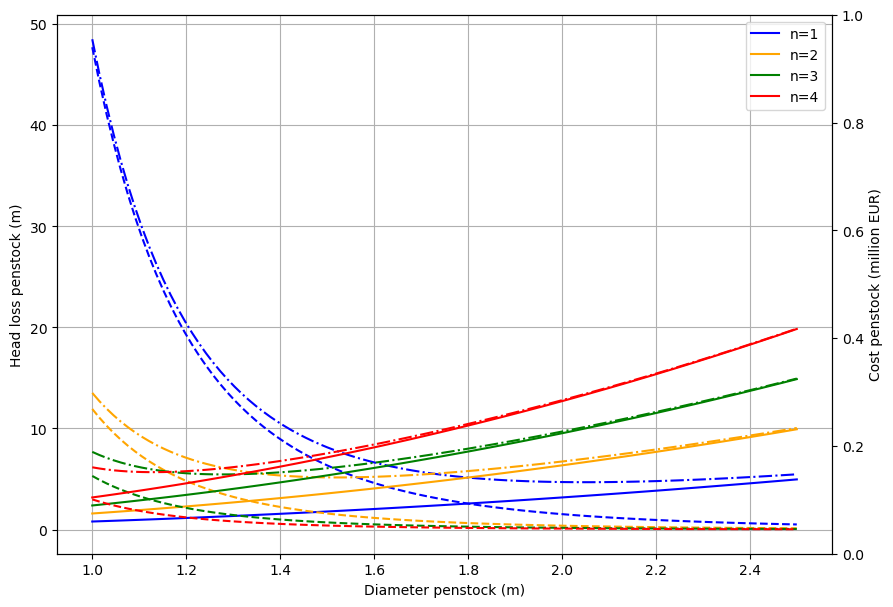

In [ ]:
D = np.linspace(1, 2.5, 100)

fig, ax = plt.subplots(figsize=(10,7))
ax2 = ax.twinx()
colors = ['blue', 'orange', 'green', 'red']
for i, n in enumerate([1, 2, 3, 4]):
    h_losses = penstock_head_loss(D, Q, l_total, n)
    # ax.plot(D, h_losses, color = "red", label=f'Head loss (m), n={n}')
    head_loss_costs_tot = head_loss_cost(Q, h_losses)

    penstock_costs_tot = penstock_costs(D, l_total, n)

    total = head_loss_costs_tot + penstock_costs_tot

    ax.plot(D, penstock_costs_tot, linestyle='-', label=f'n={n}', color=colors[i])
    ax.plot(D, head_loss_costs_tot, linestyle='--', color=colors[i])
    ax.plot(D, total, linestyle='-.', color=colors[i])

    C_min_index = np.argmin(total)
    C_min = total[C_min_index]
    D_min = D[C_min_index]
    print(f"total penstock cost for n={n} at D={D_min:.2f} m: €{penstock_costs_tot[C_min_index]:.2f} million")
    print(f"Minimum total cost for n={n} at D={D_min:.2f} m: €{C_min:.2f} million")
    print()

ax2.set_ylabel('Cost penstock (million EUR)')
ax.set_xlabel('Diameter penstock (m)')
ax.set_ylabel('Head loss penstock (m)')
ax.legend()
ax.grid()



In [153]:
elev_0 = 501
elev_s = 450
elev_p = 400

f = 0.015 #Darcy-Weisbach friction factor
D = D_req

head_0 = elev_0 + h_0
h_f = f * (V_pipe**2/(2*9.81*D)) # head loss along pipe in m/m

elev_penstock = np.zeros(10000)
x = np.linspace(0, l_total, 10000)
x_bend1 = 5300
x_bend2 = 8750
elev_penstock[np.where(x <= l_surge)] = np.linspace(elev_0, elev_s, np.sum(x <= l_surge))
elev_penstock[np.where(x > l_surge)] = np.linspace(elev_s, elev_p, np.sum(x > l_surge))

xi_ent = 0.1
xi_ex = 1.0
xi_bend = 0.5

h_f_ent = xi_ent * ((V_pipe**2)/(2*9.81)) # head loss at entrance in m
h_f_ex = xi_ex * ((V_pipe**2)/(2*9.81)) # head loss at exit in m
h_f_bend = xi_bend * ((V_pipe**2)/(2*9.81)) # head loss at bend in m

head_f = head_0 - (h_f * x)
head_f[np.where(x > x_bend1)] -= h_f_bend
head_f[np.where(x > l_surge)] -= (h_f_ex + h_f_ent)
head_f[np.where(x > x_bend2)] -= h_f_bend
head_f[-1] = head_f[-1]  - h_f_ex

print(f"total head_loss := {head_0 - head_f[-1]}")

h_f_total = (h_f * l_total) + (2*h_f_bend) + h_f_ent + (h_f_ex * 2)

print(f"bending losses: {2*h_f_bend:.2f} m")
print(f"entrance losses: {h_f_ent:.2f} m")
print(f"exit losses: {h_f_ex:.2f} m")

total head_loss := 70.26688064700471
bending losses: 1.54 m
entrance losses: 0.15 m
exit losses: 1.54 m


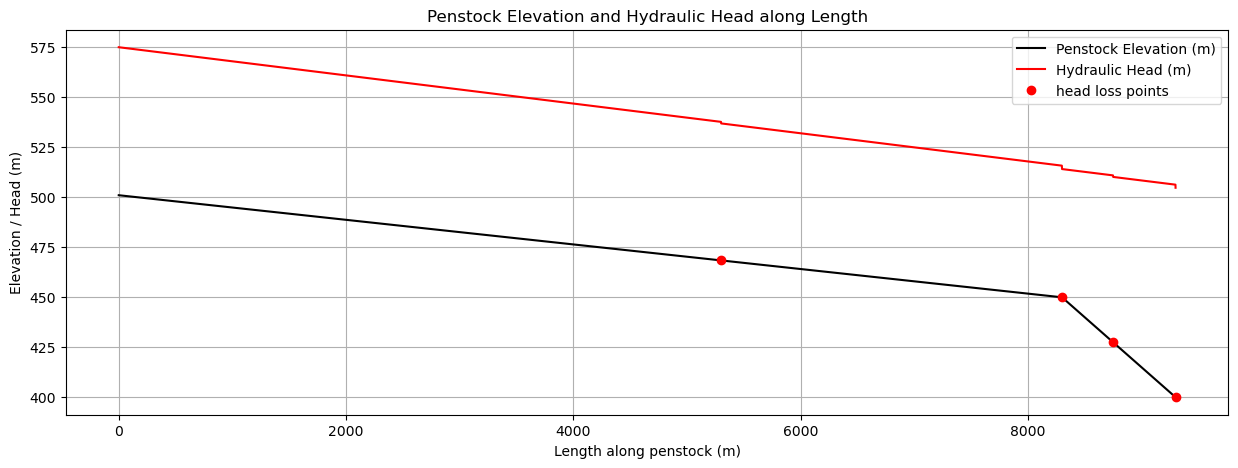

In [154]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(x, elev_penstock, label='Penstock Elevation (m)', color='black')
ax.plot(x, head_f, label='Hydraulic Head (m)', color='red')
ax.set_xlabel('Length along penstock (m)')
ax.set_ylabel('Elevation / Head (m)')
ax.set_title('Penstock Elevation and Hydraulic Head along Length')

ax.plot(x_bend1, elev_penstock[np.argmin(np.abs(x - x_bend1))], 'o', color='red', label='head loss points')
ax.plot(x_bend2, elev_penstock[np.argmin(np.abs(x - x_bend2))], 'o', color='red')
ax.plot(l_surge, elev_penstock[np.argmin(np.abs(x - l_surge))], 'o', color='red')
ax.plot(l_total, elev_penstock[-1], 'o', color='red')

ax.legend()
ax.grid()
